# Blind source separation with an unsupervised autoencoder

# Daniel Correa Tucunduva 


## Hyperparameters

In [1]:
hidden_layer_n = 10
epochs = 100

## Setup

In [2]:
%matplotlib inline

from mne.io import read_raw_eeglab
import numpy as np
from scipy.ndimage import gaussian_filter
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print(__doc__)

Using TensorFlow backend.


Automatically created module for IPython interactive environment


## Load real EEG data

In [3]:
raw_eeg_lab = read_raw_eeglab('./outside_scanner.set')
raw_eeg_lab.load_data()
np_eeg_data = raw_eeg_lab.to_data_frame()
print(np_eeg_data.shape)

n = np_eeg_data.shape[0]

Reading .\outside_scanner.fdt
Reading 0 ... 124404  =      0.000 ...   497.616 secs...


<ipython-input-3-5a9b7a979c0e>:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg_lab = read_raw_eeglab('./outside_scanner.set')


Converting "time" to "<class 'numpy.int64'>"...
(124405, 64)


## ICA

In [4]:
# ica = FastICA(n_components=3)  # we'll be generous and assume there's 3
# ica.fit(reshape_mixed.T)  # .T because 100000 instances, 100 attributes
# ica_comps = ica.transform(reshape_mixed.T)  # get the components
# ica_weights = np.reshape(ica.components_.T, [10, 10, 3])  # visualize these as images

## Autoencoder training

In [5]:
autoencoder = Sequential()
autoencoder.name = 'autoencoder'
autoencoder.add(Dense(hidden_layer_n, activation='linear', input_shape=[64], kernel_initializer='uniform', use_bias=False, kernel_constraint='nonneg'))
autoencoder.add(Dense(64, activation='linear', kernel_initializer='uniform', use_bias=False, kernel_constraint='nonneg'))

autoencoder.summary()

optimizer = keras.optimizers.SGD(learning_rate=1e-1, momentum=0.0, nesterov=False)

autoencoder.compile(loss='logcosh', optimizer=optimizer)

autoencoder_input = np_eeg_data

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                640       
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
_________________________________________________________________


In [6]:
        
def learning_rate_schedule(epoch):
    e = epoch + 1
    if e > 80:
        return 1e-8
    if e > 60:
        return 1e-7
    if e > 40:
        return 1e-6
    if e > 20:
        return 1e-5
    return 1e-4

    
autoencoder_history = autoencoder.fit(autoencoder_input,
                                      autoencoder_input,
                                      batch_size=40,
                                      epochs=epochs,
                                      verbose=1,
                                      callbacks=[
                                      LearningRateScheduler(learning_rate_schedule)
                                      ])

Epoch 1/100
124405/124405 [==============================] - 3s 22us/step - loss: 15.3302
Epoch 2/100
124405/124405 [==============================] - 3s 24us/step - loss: 13.2789
Epoch 3/100
124405/124405 [==============================] - 4s 29us/step - loss: 13.1272
Epoch 4/100
124405/124405 [==============================] - 3s 25us/step - loss: 12.7896
Epoch 5/100
124405/124405 [==============================] - 3s 25us/step - loss: 12.3362
Epoch 6/100
124405/124405 [==============================] - 3s 23us/step - loss: 11.9804
Epoch 7/100
124405/124405 [==============================] - 3s 23us/step - loss: 11.7421
Epoch 8/100
124405/124405 [==============================] - 3s 23us/step - loss: 11.5512
Epoch 9/100
124405/124405 [==============================] - 3s 25us/step - loss: 11.3885
Epoch 10/100
124405/124405 [==============================] - 3s 24us/step - loss: 11.2521
Epoch 11/100
124405/124405 [==============================] - 5s 36us/step - loss: 11.1314
Epoch 12

124405/124405 [==============================] - 3s 24us/step - loss: 9.9142
Epoch 92/100
124405/124405 [==============================] - 3s 21us/step - loss: 9.9142
Epoch 93/100
124405/124405 [==============================] - 3s 22us/step - loss: 9.9142
Epoch 94/100
124405/124405 [==============================] - 3s 22us/step - loss: 9.9142
Epoch 95/100
124405/124405 [==============================] - 3s 22us/step - loss: 9.9142
Epoch 96/100
124405/124405 [==============================] - 3s 20us/step - loss: 9.9142
Epoch 97/100
124405/124405 [==============================] - 3s 24us/step - loss: 9.9142
Epoch 98/100
124405/124405 [==============================] - 3s 22us/step - loss: 9.9142
Epoch 99/100
124405/124405 [==============================] - 3s 22us/step - loss: 9.9142
Epoch 100/100
124405/124405 [==============================] - 3s 21us/step - loss: 9.9142


In [7]:
reconstruction = autoencoder.predict(autoencoder_input)

## Original and reconstruction comparison

## Recover independent sources from hidden layer

In [8]:
hidden_layer = Sequential()
hidden_layer.name = 'hidden_layer'
hidden_layer.add(Dense(hidden_layer_n, input_shape=[64], use_bias=False, kernel_constraint='nonneg'))
hidden_layer.summary()

hidden_layer.set_weights(autoencoder.get_weights())

recovered_sources = hidden_layer.predict(autoencoder_input)

names = []
sources = []
for i in range(hidden_layer_n):
    names.append('source_' + str(i))
    sources.append(np.reshape(recovered_sources.T[i], [n, 1]))

Model: "hidden_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                640       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


## ICA and autoencoder results comparison

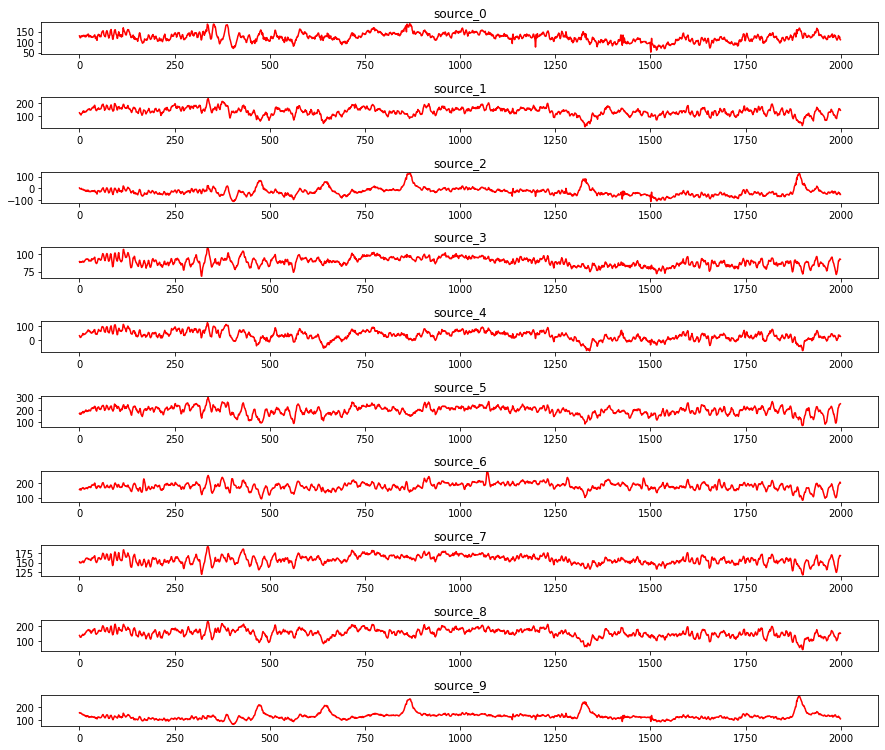

In [9]:
plt.figure(figsize=(15, 15))

models = sources
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(hidden_layer_n * 2 + 2, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig[0:2000], color=color)
plt.show()